<h1 align=center>Brain Tumor Classification </h1>

# New Section

In [ ]:
import PIL.Image as Image
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/archive (1)'

In [ ]:
# Creating dataframe by iterating through filepaths
import pathlib
tumor_dir= pathlib.Path("/content/drive/MyDrive/archive (1)/no")
healthy_dir=pathlib.Path("/content/drive/MyDrive/archive (1)/yes")


In [ ]:
dirlist=[tumor_dir,healthy_dir ]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  3045    labels:  3045


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(3045,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/archive (1)/no/no232.jpg,No
1,/content/drive/MyDrive/archive (1)/no/no1340.jpg,No
2,/content/drive/MyDrive/archive (1)/no/no1150.jpg,No
3,/content/drive/MyDrive/archive (1)/no/no1187.jpg,No
4,/content/drive/MyDrive/archive (1)/no/no282.jpg,No


In [ ]:
print(df['labels'].value_counts())

Yes    1534
No     1511
Name: labels, dtype: int64


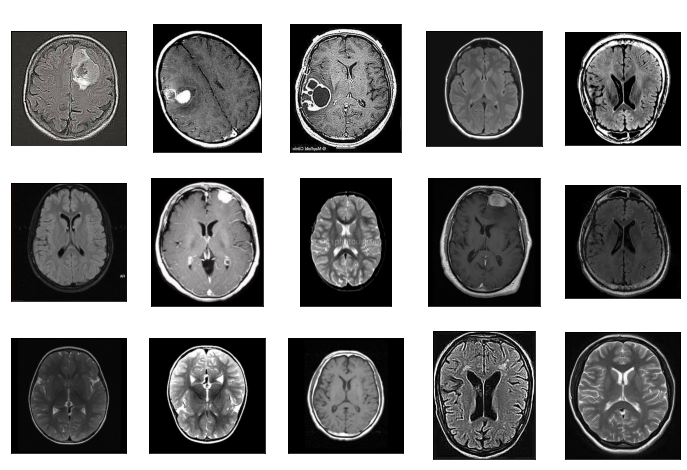

In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
images_dict = {
    'Cancer': list(tumor_dir.glob('*')) ,
    'healthy': list(healthy_dir.glob('*'))
}

labels_dict = {
    'Cancer': "cancer",
    'healthy': "healthy",

}

In [ ]:
img= cv2.imread(str(images_dict['healthy'][0]))
img.shape

(340, 291, 3)

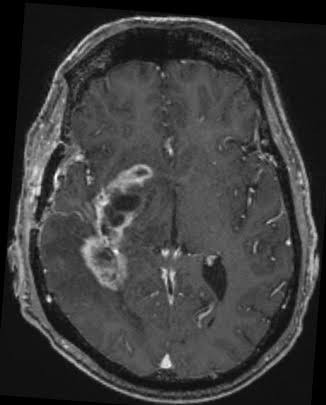

In [ ]:
Image.open(str(images_dict['healthy'][100]))

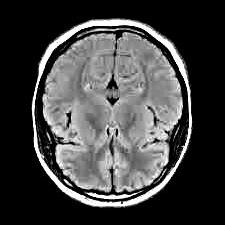

In [ ]:
Image.open(str(images_dict['Cancer'][100]))

In [ ]:
X, y = [], []
for name,images in images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)

        #resize_img=cv2.resize(img,(224,224))

        X.append(img)
        y.append(labels_dict[name])

In [ ]:
Fseries = pd.Series(X, name="filepaths",dtype=str)
Lseries = pd.Series(y, name="labels",dtype=str)
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)

print(tumor_df.head())
print("---------------------")
print(tumor_df["labels"].value_counts())

                                          filepaths  labels
0   /content/drive/MyDrive/archive (1)/no/no232.jpg  cancer
1  /content/drive/MyDrive/archive (1)/no/no1340.jpg  cancer
2  /content/drive/MyDrive/archive (1)/no/no1150.jpg  cancer
3  /content/drive/MyDrive/archive (1)/no/no1187.jpg  cancer
4   /content/drive/MyDrive/archive (1)/no/no282.jpg  cancer
---------------------
healthy    1534
cancer     1511
Name: labels, dtype: int64


In [ ]:
tumor_df.shape

(3045, 2)

Splitting Tumor Data using train_test_split

In [ ]:
#splitting data
from sklearn.model_selection import train_test_split
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [ ]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(2436, 2)
(914, 2)
(609, 2)
(2131, 2)


ImageDataGenerator

In [ ]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 2436 validated image filenames belonging to 2 classes.
Found 913 validated image filenames belonging to 2 classes.
Found 608 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


In [ ]:
#Defining Sequential Model
cnn= Sequential([
                        #cnn layer
                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(244,244,3)),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dropout(rate=0.3),
                        layers.Dense(64, activation="relu"),
                        layers.Dense(2, activation="sigmoid")

])


In [ ]:
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 119072)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [ ]:
History = cnn.fit(train, validation_data= val, epochs=11,verbose=1)

Epoch 1/11
11/77 [===>..........................] - ETA: 12:55 - loss: 1.8755 - accuracy: 0.5625

In [ ]:
cnn.evaluate(test)

NameError: ignored

**Visualizing Accuracy and Loss**

In [ ]:
plt.figure(figsize=(10,5))
epochs=range(1,len(History.history['val_accuracy'])+1)

plt.plot(epochs,History.history["accuracy"])
plt.plot(epochs,History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
epochs=range(1,len(History.history['val_loss'])+1)

plt.plot(epochs,History.history["loss"])
plt.plot(epochs,History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

from keras.models import load_model
cnn.save("network.h5")
loaded_model = load_model("network.h5")


In [ ]:
#Hemal Shingloo flask documentations